### Test undistortion on an image

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

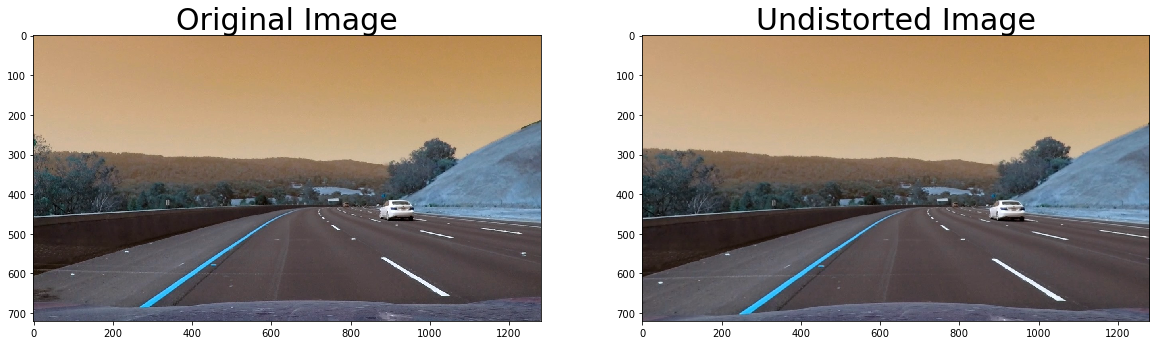

In [287]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./test_images/test3.jpg')
# img = cv2.imread('./test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size ,None,None)

undist_img = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('./test_images/test4_undistort.jpg',undist_img)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open( "./camera_cal/cam_cal_pickle.p", "wb" ) )

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

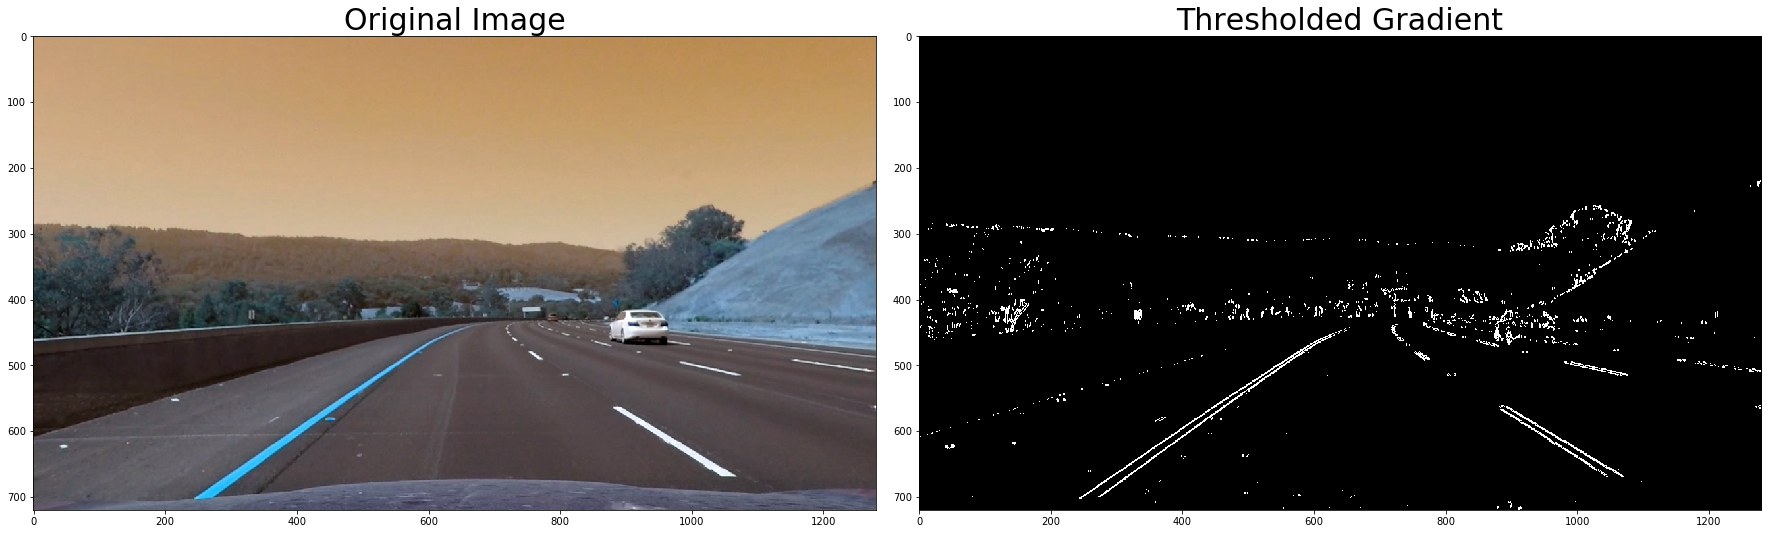

In [288]:
def abs_sobel_thresh(img, orient='x',sobel_kernel= 9, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

image = undist_img
# # Test Run the function , with orient orient='y'
# blured_image =  gaussian_blur(image, kernel_size= 9)
grad_binary_full = abs_sobel_thresh(image, orient='x',sobel_kernel= 9, thresh=(30,150))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary_full, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

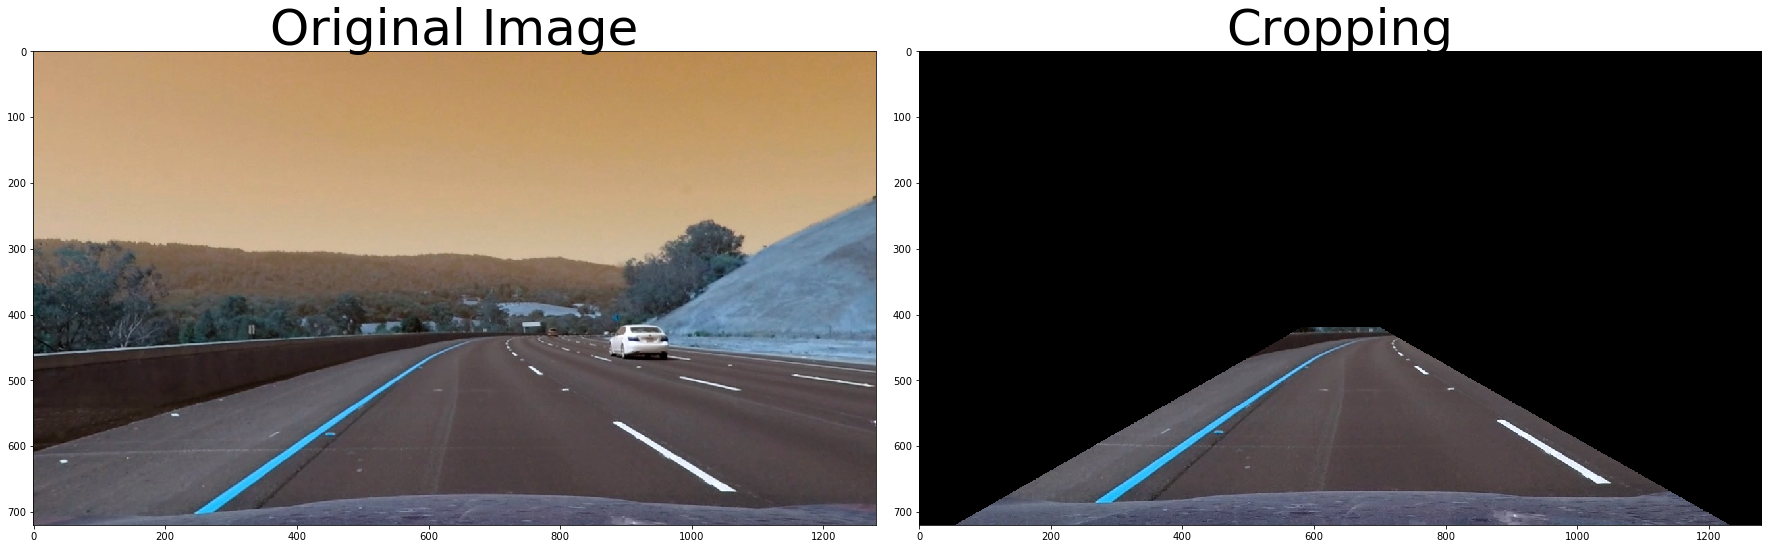

In [289]:
# defining a four sided polygon to mask
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
max_x = imshape[1]
max_y = imshape[0]
center_x = imshape[1]/2
center_y = imshape[0]/2
vertices = np.array([[(55,imshape[0]),
                     (imshape[1]/2-60, imshape[0]/2+60), 
                     (imshape[1]/2+60, imshape[0]/2+60), 
                     (imshape[1]-50,imshape[0])]], dtype=np.int32)

cropped_img = region_of_interest(img, vertices)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cropped_img)
ax2.set_title('Cropping', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

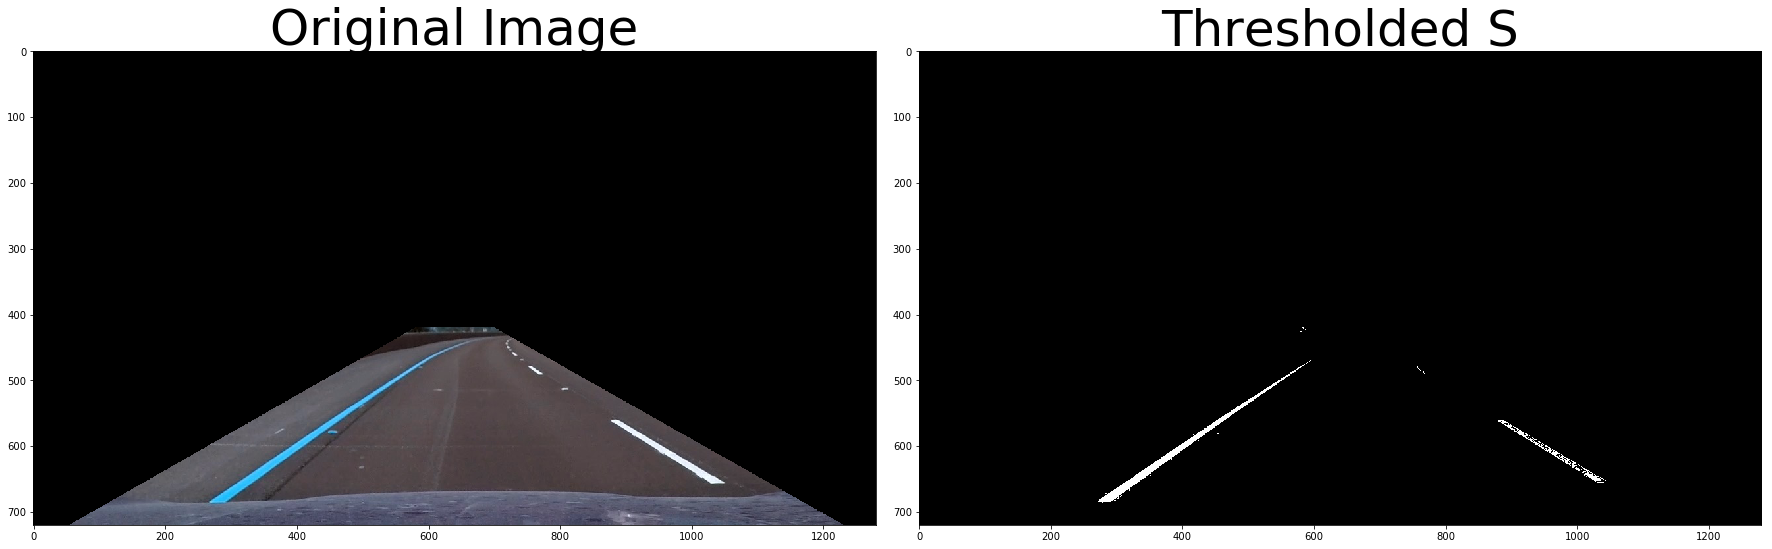

In [290]:
image = cropped_img
# Define a function that thresholds the S-channel of HLS
def hls_select(img, channel = 'H' , thresh=(-1,1)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'H':
        out_channel = hls[:,:,0]
    elif channel == 'L':
        out_channel = hls[:,:,1]
    else :
        out_channel = hls[:,:,2]
    
#     normalized = (out_channel - np.mean(out_channel) )/np.std(out_channel)
#     normalized = out_channel/255.0-0.5
    normalized = (out_channel-np.min(out_channel))/(np.max(out_channel) - np.min(out_channel))
    binary_output = np.zeros_like(out_channel)
    binary_output[(normalized > thresh[0]) & (normalized <= thresh[1])] = 1
    return binary_output

# s_binary = hls_select(image,channel = 'S', thresh=(210/255.0-0.5, 255/255.0-0.5))
s_binary = hls_select(image,channel = 'S', thresh=(180/255, 255/255.0))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

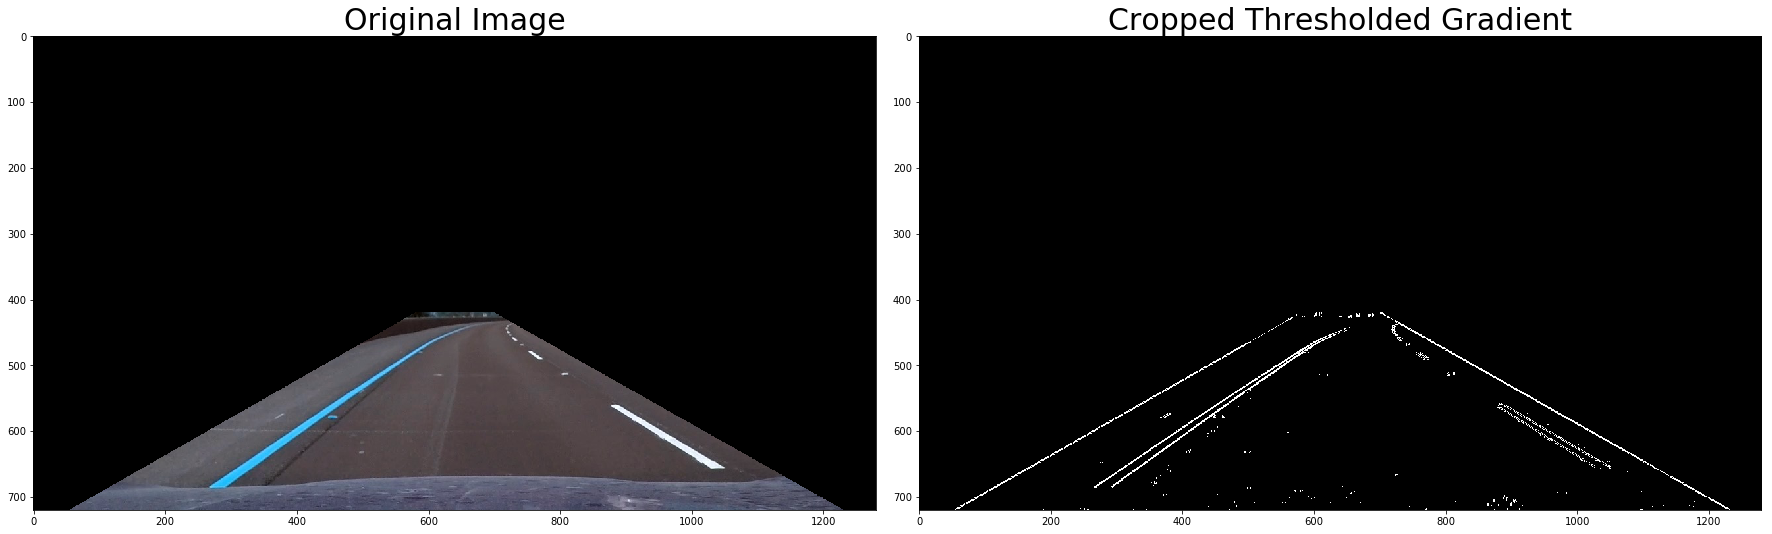

In [291]:
def abs_sobel_thresh(img, orient='x',sobel_kernel= 9, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# # Test Run the function , with orient orient='y'
# blured_image =  gaussian_blur(image, kernel_size= 9)
grad_binary_cropped = abs_sobel_thresh(image, orient='x',sobel_kernel= 9, thresh=(30,120))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary_cropped, cmap='gray')
ax2.set_title('Cropped Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

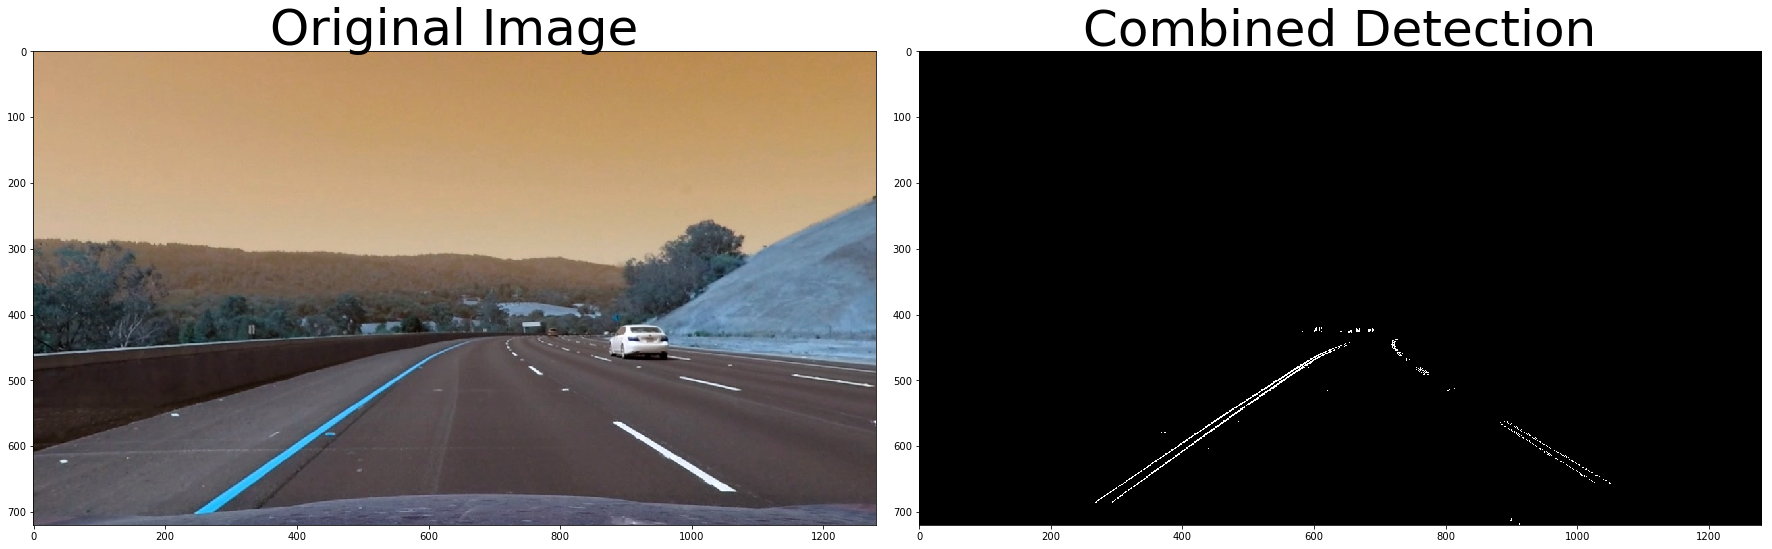

In [292]:
combined = np.zeros_like(s_binary)
combined[((grad_binary_cropped == 1) & (grad_binary_full == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combining Full & Cropped Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

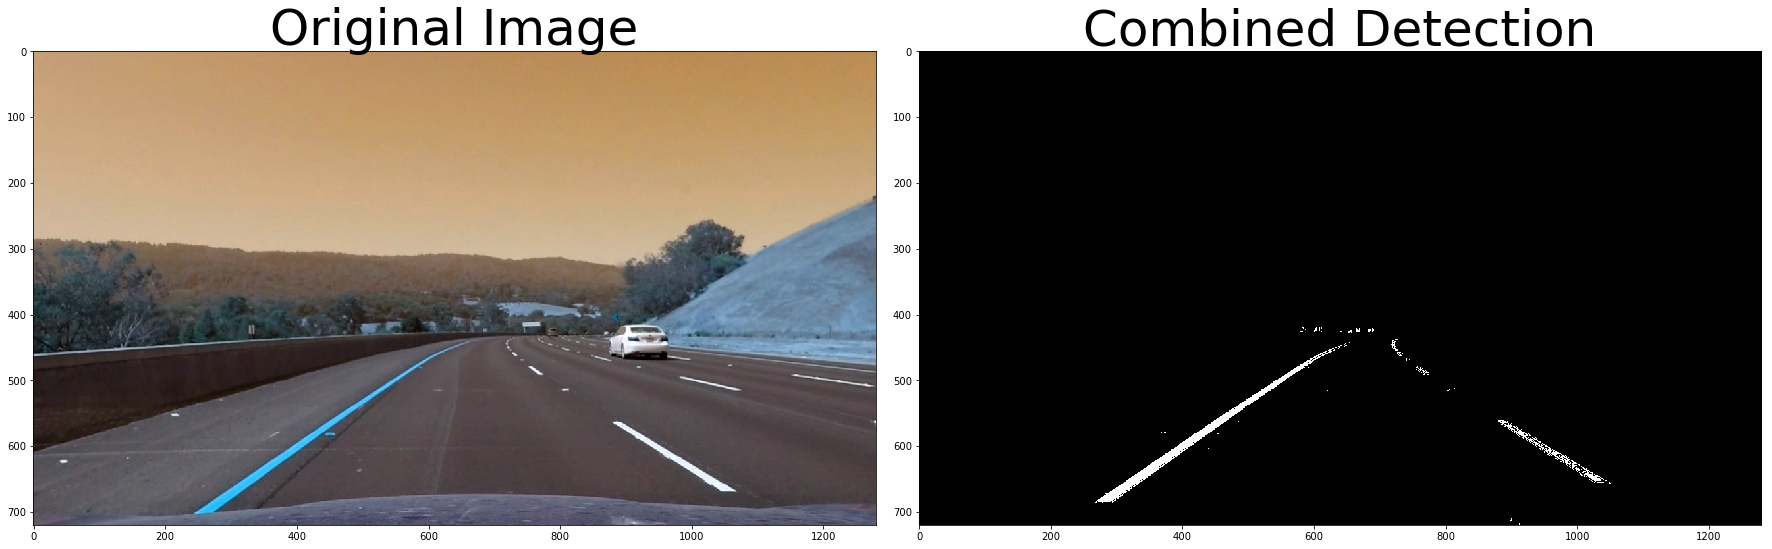

In [293]:
combined = np.zeros_like(s_binary)
combined[(s_binary==1) | ((grad_binary_cropped == 1) & (grad_binary_full == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Detection', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  Apply a perspective transform to rectify binary image ("birds-eye view")

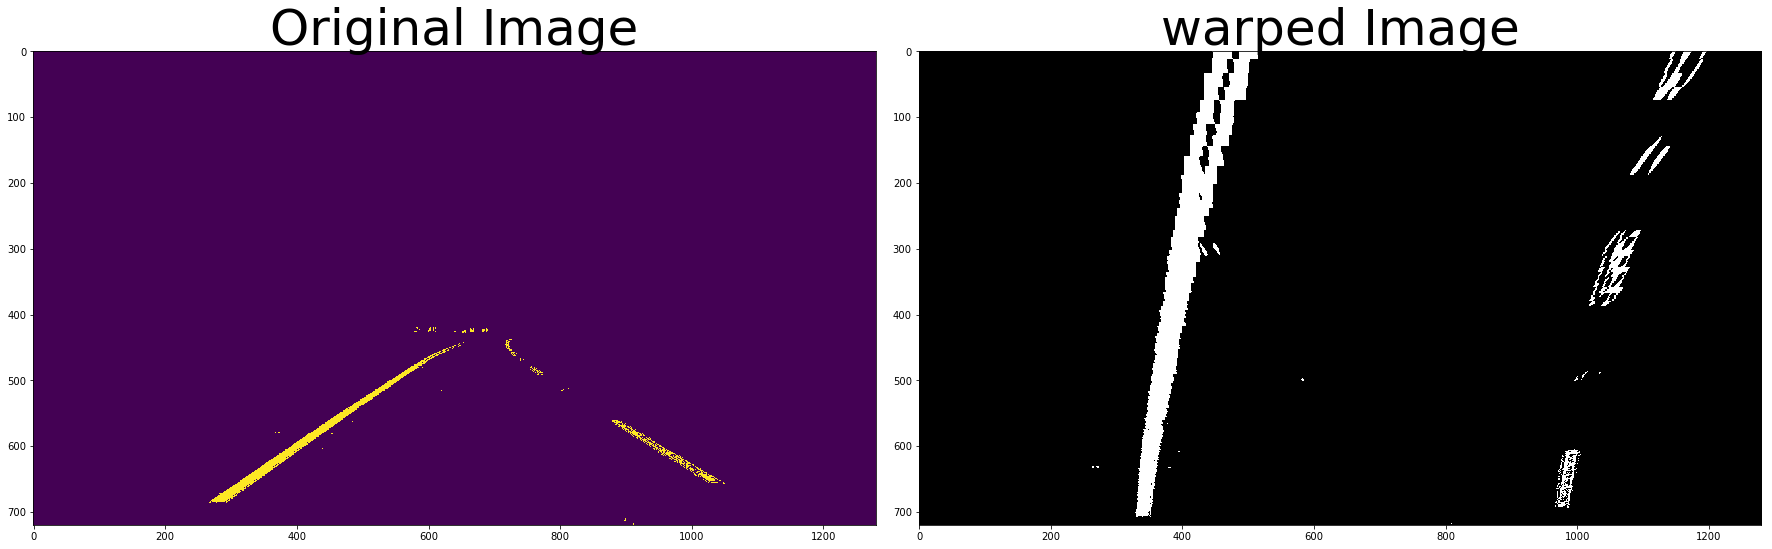

In [294]:
offset = 100
img_size = (imshape[1],imshape[0])
# img_size = (imshape[0],imshape[1])

# src = np.float32([[center_x-60, center_y+60], 
#                   [center_x+60, center_y+60], 
#                   [max_x-50,max_y],
#                   [50 , max_y]])

# dst = np.float32([[offset, 0],
#                   [img_size[0]-offset, 0], 
#                   [img_size[0]-offset, img_size[1]], 
#                   [offset, img_size[1]]])

# src = np.float32([[100, center_y+60], 
#                   [max_x-100, center_y+60], 
#                   [max_x,max_y],
#                   [0 , max_y]])


# src = np.float32([ [532,509],[796,509],[1016,628],[ 384 ,628] ])


# ##### Vertices extracted manually for performing a perspective transform
# # bottom_left = [220,720]
# # bottom_right = [1110, 720]
# # top_left = [570, 470]
# # top_right = [722, 470]

# bottom_left = [220,720]
# bottom_right = [1110, 720]
# top_left = [570, 440]
# top_right = [722, 440]

# src = np.float32([bottom_left,bottom_right,top_right,top_left])

# # pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
# # pts = pts.reshape((-1,1,2))
# # copy = img.copy()
# # cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
# bottom_left = [320,720]
# bottom_right = [920, 720]
# top_left = [320, 1]
# top_right = [920, 1]

# dst = np.float32([bottom_left,bottom_right,top_right,top_left])
# ####################################################################
src = np.float32([ [585,460],[203,720],[1127,720],[ 695, 460] ])
dst = np.float32([ [320, 0],[320, 720],[960, 720],[ 960, 0] ])

warp_M = cv2.getPerspectiveTransform(src, dst)
warp_Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(combined, warp_M, img_size)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  Implement Sliding Windows and Fit a Polynomial

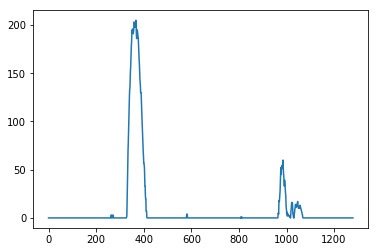

In [295]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = warped
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [296]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
distance_left_right = np.int32(rightx_base - leftx_base)

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

leftx,lefty,rightx,righty = [] , [], [], []
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
#     #########    
#     if (len(good_left_inds) < minpix) & (len(good_right_inds) > minpix):
#         left_lane_inds.append(list(np.array(good_right_inds) - distance_left_right))
        
#     if (len(good_right_inds) < minpix) & (len(good_left_inds) > minpix):
#          right_lane_inds.append(list(np.array(good_left_inds) + distance_left_right))
#     #########
   
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

#######
rightx_2_leftx =  rightx - distance_left_right
leftx_2_rightx =  leftx  + distance_left_right
leftx = np.concatenate((leftx , rightx_2_leftx))
rightx = np.concatenate((rightx , leftx_2_rightx))

righty_2_lefty = righty
lefty_2_righty = lefty
lefty = np.concatenate((lefty , righty_2_lefty))
righty = np.concatenate((righty , lefty_2_righty))
#######

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [297]:
len(lefty) ==  len(righty)

True

#### Visualization

(720, 0)

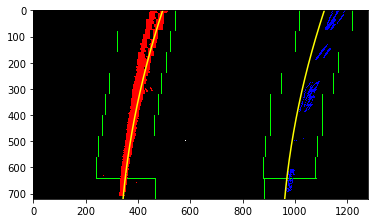

In [298]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Skip the sliding windows step once you know where the lines are

In [299]:
# ## Assume you now have a new warped binary image 
# ## from the next frame of video (also called "binary_warped")
# ## It's now much easier to find line pixels!
# nonzero = binary_warped.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# margin = 100
# left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
# right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# ## Again, extract left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds]

# ## Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# ## Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#### Visualization

(720, 0)

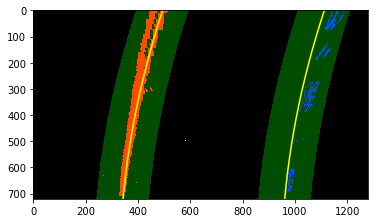

In [300]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Measuring Curvature

In [301]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
left_fit = left_fitx
right_fit =  right_fitx

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

3.64288950949e+14 1.84389038529e+15


#### Scale to real world

In [302]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
leftx = left_fitx
rightx = right_fitx
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curvature_text_on_img = "Radius of curvature: %.2f m" % right_curverad

# Now our radius of curvature is in meters
print('left  curvature = {}'.format(left_curverad) + 'm')
print('right curvature = {}'.format(right_curverad) + 'm')

# distance from the lane center
lane_center = (right_fitx[719] + left_fitx[719])/2
center_offset_pixels = abs(imshape[1]/2 - lane_center)
distance_from_center = xm_per_pix*center_offset_pixels
distance_from_center_text_on_imag = "Distance from the lane center: %.2f m" % distance_from_center
print('Distance from the lane center = {}'.format(distance_from_center) + 'm')

left  curvature = 991.2383889111123m
right curvature = 991.2383889114267m
Distance from the lane center = 0.0647719279907447m


### Unwarp result and overlap to the original image

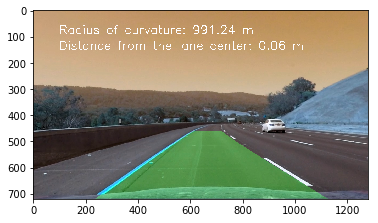

In [303]:
# Create an image to draw the lines on
warp = result
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, warp_Minv, (image.shape[1], image.shape[0]))

# Combine the result with the original image
overlayed_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
cv2.putText(overlayed_result,curvature_text_on_img , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(overlayed_result, distance_from_center_text_on_imag, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

plt.imshow(overlayed_result)